In [1]:
%load_ext autoreload
%autoreload 2

# Part 1: ECM

In [2]:
import numpy as np

# Parameters and experimental data 
from utils.load_data import get_exp_data
from utils.known_parameters import params_func
params = params_func()
from utils.geometry_params import T, c_e, c_n, volume_anode, area_electrode, i_0_a, e_a, s_thick 

# Optimizing codes
from utils.optimize import optimize_diff

# ECM (Randles) functions
from utils.Z_randles import calc_randles_Z, a_randles

# Plotting codes
from utils.EIS_plot import plot_impedance
from utils.all_sets_plot import plot_all_sets

Comparing fitted ECM with the experimental data set 1 (zero degradation): 

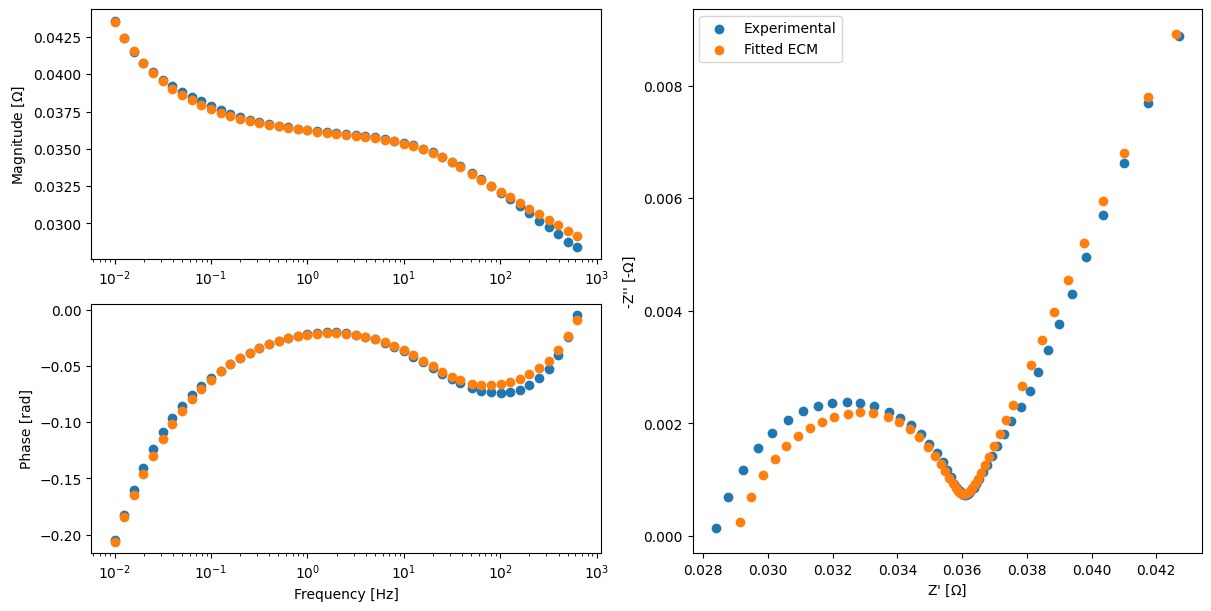

In [3]:
# The impedance for chosen experimental data set (here: 1)
i = 1
freq = np.array(get_exp_data(i, "")[1])
exp_real = np.array(get_exp_data(i, "")[0][0])
exp_imag = np.array(get_exp_data(i, "")[0][1])
Z_exp = exp_real + exp_imag*1j

# The optimized Randles parameters
final_diff, opt_randles_param = optimize_diff(i, a_randles, calc_randles_Z)
Z_randles_opt = calc_randles_Z(opt_randles_param, freq)

# Plotting
plot_impedance([(freq, Z_exp), 
                (freq, Z_randles_opt)], ['Experimental', 'Fitted ECM'])

e_s = params['Negative electrode porosity']
Rel = (((params['Electrolyte conductivity [S.m-1]'](c_e, T)*e_s**params['Negative electrode Bruggeman coefficient (electrolyte)'])*s_thick))/area_electrode
#print(Rel)

Plotting fitted ECM for all datasets:

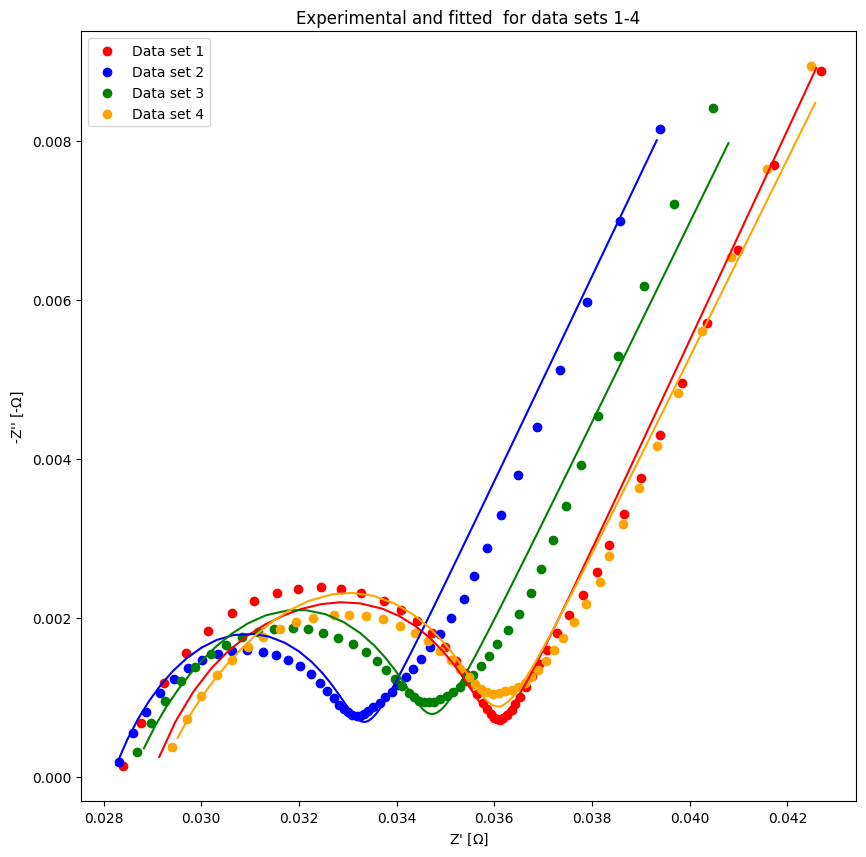

In [4]:
plot_all_sets('', a_randles, calc_randles_Z, optimize_diff)

# Part 2: PyBaMM

Assumptions:
- DFN model
- same parameters as I got from Amund
- input parameter SoC - 45% 
- at 25 degrees C
- using the numerical prebicgstab frequency domain method 


In [5]:
# Parameters 
from utils.known_parameters import params_func
params_pb = params_func()

# Setting SOC 
from utils.pybamm_plot import set_SOC
set_SOC(params_pb, 0.45)

# Calculation code for impedance
from utils.Z_pybamm import calc_pybamm_Z


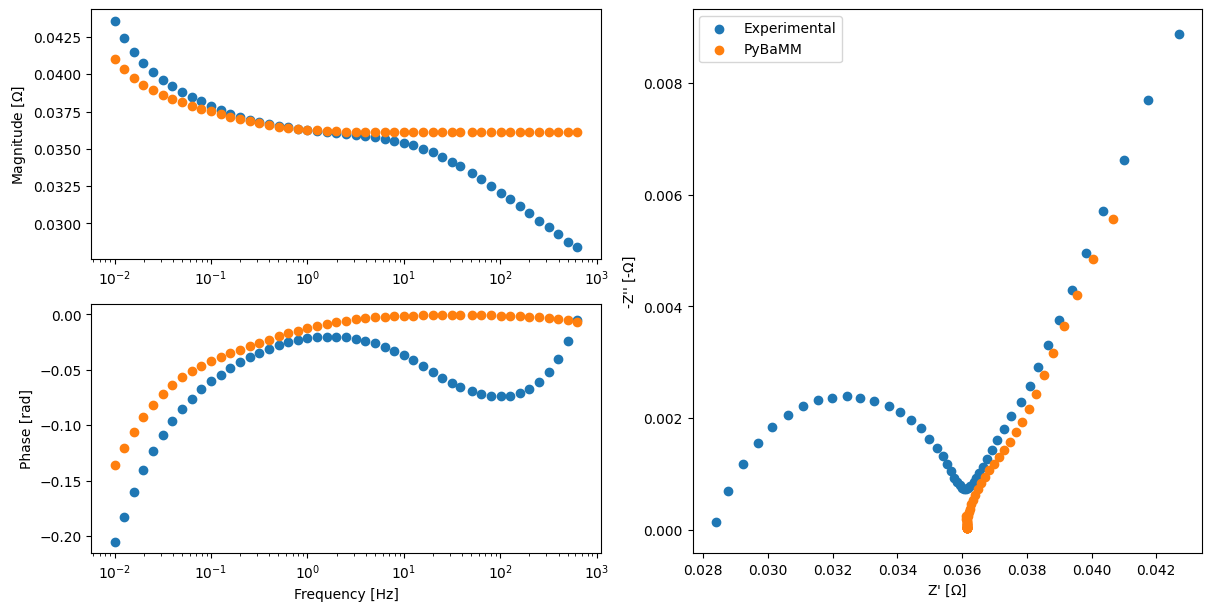

In [6]:
# Adding an ohmic resistance called Rel to align the plots
Rel = .03
Z_pybamm_before = calc_pybamm_Z(1, params_pb, Rel)

plot_impedance([(freq, Z_exp), 
                (freq, Z_pybamm_before)
                ], ['Experimental', 'PyBaMM'])

As seen, the Pybamm simulation does not fit with the experimental graph. Further, I am finding the "correct" Pybamm parameters from the fitted Randles circuit!

#### Modifying parameters

In [7]:
# The optimized Randles parameters
final_diff, opt_randles = optimize_diff(1, a_randles, calc_randles_Z)

# Convertion code (between dictionary and list and back)
from utils.convertion import dict_to_list, list_to_dict

# Geometry parameters
from utils.geometry_params import area_electrode, R, T, F, z 



In [8]:
opt_elems = list_to_dict(a_randles, opt_randles) 

# Parameters I want to change to optimize the simulation graph: 
params_pb_new = params_pb
params_pb_new.update({
    #Capacity - analog to Cdl/CPE in the Randles circuit 
    'Negative electrode double-layer capacity [F.m-2]': opt_elems.get('Q2')**opt_elems.get('alpha2')/area_electrode, 
    'Positive electrode double-layer capacity [F.m-2]': opt_elems.get('Q1')**opt_elems.get('alpha1')/area_electrode, 

    #Exchange current density - relation to Rct in the Randles circuit through the Butler-Volmer 
    "Positive electrode exchange-current density [A.m-2]": (R*T)/(z*F*opt_elems.get('R_ct1')), 
    "Negative electrode exchange-current density [A.m-2]": (R*T)/(z*F*opt_elems.get('R_ct2')), 
     })


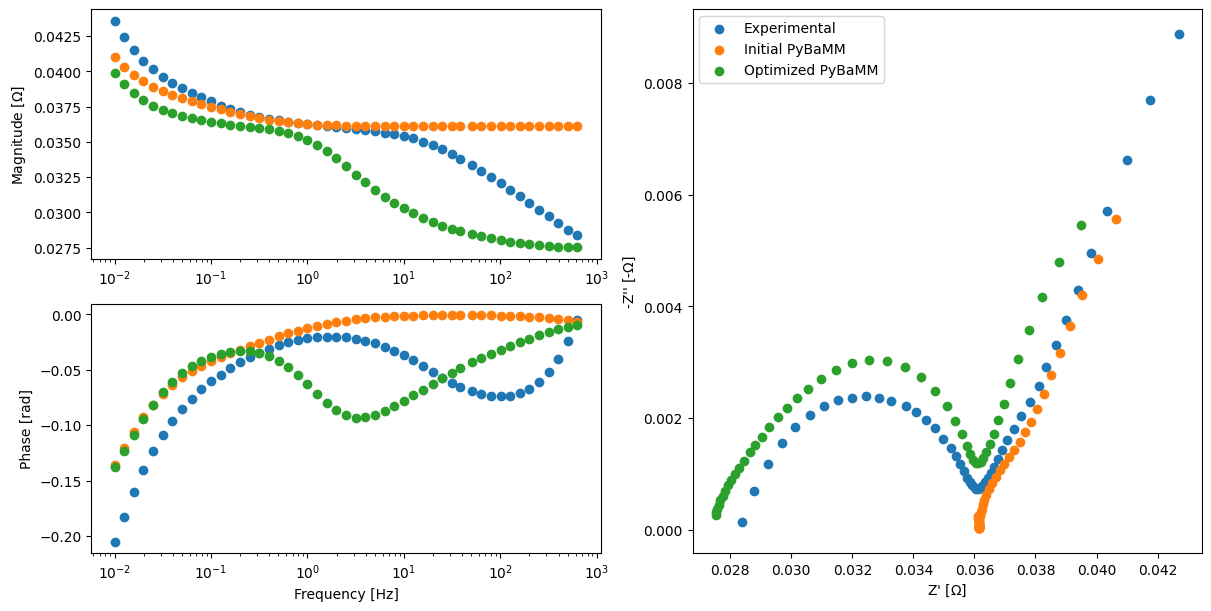

In [9]:
# Adding an ohmic resistance called Rel to align the plots
Rel = .023
Z_pybamm_after = calc_pybamm_Z(1, params_pb_new, Rel)

plot_impedance([(freq, Z_exp), 
                (freq, Z_pybamm_before), 
                (freq, Z_pybamm_after)
                ], ['Experimental', 'Initial PyBaMM', 'Optimized PyBaMM'])

# Part 3: Meyers model

The resistance to solid-phase diffusion within a single particle is expressed as 

$$R_{part} = \left(-\frac{\partial U}{\partial c_s}\right)\frac{R_s}{FD_s}$$

The admittance of a single particle at a given frequency, $Y(\omega)$, is related to the the double layer capacitance, the intercalation process, and reaction kinetics at the pore surface. $Y(\omega)$ is given by 

$$Y(\omega) = \frac{1}{\frac{R1 + \frac{R_{part}}{Y_s}}{1 + j\omega C1\left(R1 + \frac{R_{part}}{Y_s}\right)} + \frac{R2}{1+j\omega R2\cdot C2}},$$

where $Y_s$ is the admittance for the diffusion effect: 

$$Y_s = \frac{\sqrt{j\Omega_s}-\tanh(\sqrt{j\Omega_s})}{\tanh(\sqrt{j\Omega_s})}$$

Here, $\Omega_s$ is the dimensionless frequency: 

$$\Omega_s = \frac{\omega R_s^2}{D_s}$$

Further, $\overline{aY}$ is the average admittance in the porous electrode, and a function of frequency $v$ can be defined: 

$$v = \frac{L}{\left(\frac{K\sigma}{K + \sigma}\right)^{\frac{1}{2}}\left({\overline{aY}}\right)^{-\frac{1}{2}}}$$
 
Finally, the total impedance is expressed by the $v(\omega)$ function: 

$$Z = \frac{L}{K+\sigma}\left[1 + \frac{2 + (\frac{\sigma}{K} + \frac{K}{\sigma})\cosh v}{v\cdot \sinh v}\right]$$




### Meyers parameters

+ $R1$ - resistance 
+ $R2$ - resistance 
+ $C1$ - capicitance 
+ $C2$ - capicitance 
+ $R_s$ - particle size (assuming radius)
+ $D_s$ - diffusion coefficient 
+ $a$ - surface area of pores per volume electrode
+ $L$ - electrode thickness
+ $K$ - electrolyte conductivity 
+ $\sigma$ - electrode conductivity 
+ $\epsilon$ - porosity 
+ $\left(-\frac{\partial U}{\partial c_s}\right)$

These parameters are defined from the given parameters by supervisoir (in the utils folder: known_parameters). If the Meyer parameter does not have an equivalent in the parameter list above, it is calculated from relations (for example, the resistances $R1$ and $R2$ are calculated from the exhange current density $i_0$). 


### Calculating the Meyers parameters which are not defined in the given parameter lists:


The charge transfer resistances (= $R_{ct}$), $R1$ and $R2$, are found from the Butler-Volmer equation: 

$$R_{ct} = \frac{RT}{n\cdot i_0(\alpha_a + \alpha_c)F}, $$

at small overpotentials and assuming a symmetrical charge transfer process $(\alpha_a + \alpha_c = 1)$. This equation is also written as equation $(20)$ in the Meyers paper. 

In [10]:
from utils.R_ct import R_ct

R1_a = R_ct(i_0_a)


####  Equation for finding the pore surface volume divided by the electrode volume (=$a$):

The pore surface area can be found from the following calculations: 

$$V_{particle} = \frac{4\pi r^3}{3}$$
$$V_{active} = \epsilon \cdot V_{electrode}, $$

where $\epsilon$ is the fraction of active electrode material and then $V_{active}$ is the volume of the active electrode material. This gives the number of particles $N = \frac{V_{active}}{V_{particle}}$. Further, the surface area of one particle is 

$$A_{particle} = 4 \pi r^2, $$

so that $A_{total} = N\cdot A_{particle}$, where $A_{total}$ is the total pore/particle surface area. 

Then $a$ is calculated from 

$$a = \frac{A_{total}}{V_{electrode}}$$




In [11]:
from utils.pore_surface_area import a 

area_pore = a(volume_anode, e_a)

### The resulting Meyers parameter set 

For the anode only (R2 and C2 are not included).

In [12]:
# Potential gradient as a function of concentration 
from utils.potential_gradient import _dU_dc_anode

# Porosity in anode = fraction of electrolyte in anode
e_s = params['Negative electrode porosity']


# Meyers component parameters
a_meyers_initial = {
    "Rel": 0.003, 
    "R1": R1_a, 
    "C1": params['Negative electrode double-layer capacity [F.m-2]'],
    "Rs": params['Negative particle radius [m]'], 
    "Ds": params['Negative electrode diffusivity [m2.s-1]'],
    "a": a(volume_anode, e_a),  
    "L": params['Negative electrode thickness [m]'],  
    "K" : params['Electrolyte conductivity [S.m-1]'](c_e, T)*e_s**params['Negative electrode Bruggeman coefficient (electrolyte)'], 
    "sigma": params['Negative electrode conductivity [S.m-1]'], 
    "ebsilon": e_a,     
    "-dU_dcs": _dU_dc_anode(c_n), 
    }


# Dataset 1: Fitting parameters to experimental data

An electrolyte resistance is added to move all simulated plot to the experimental. The additional changes are done in the following parameter sets: 
+ "a_meyers": R1, R2, C1, C2, Ds and a are optimized 
+ "a_meyers_K": R1, R2, C1, C2, Ds, a and K are optimized
+ "a_meyers_all": All parameters are optimized, plus an inductance term to modify the semicircle. 

Here, I will use the parameter list "a_meyers" and compare with "a_meyers_initial" with original parameters from the known parameter list. 

In [13]:
# Original parameters and the original impedance Z 
from utils.meyers_initial_plot import calc_meyers_initial_Z, a_meyers_initial

# Change in R1, R2, C1, C2, Ds and a 
from utils.Z_meyers import calc_meyers_Z, a_meyers

# Parameters
from utils.known_parameters import params_func 
params = params_func()

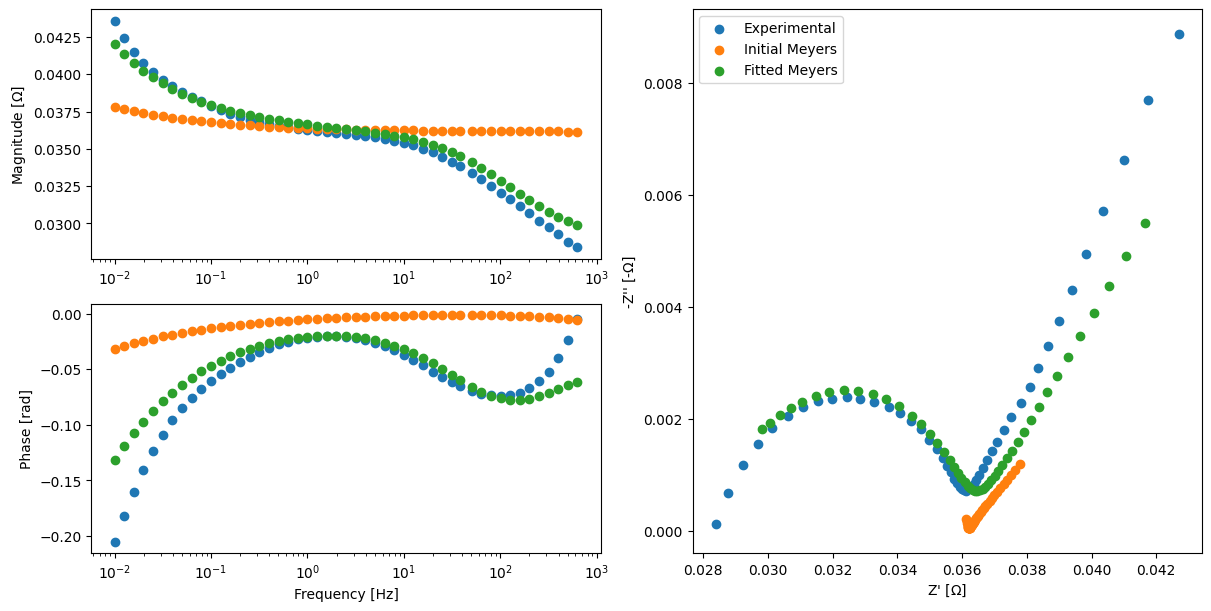

In [14]:

# The initial impedance from Meyers
Z_meyers_initial = calc_meyers_initial_Z(dict_to_list(a_meyers_initial), freq)

# The optimized Meyers impedance for data set 1 
final_diff, list_meyers = optimize_diff(1, a_meyers, calc_meyers_Z)
Z_meyers_opt = calc_meyers_Z(list_meyers, freq)

# Plotting to compare 
plot_impedance([(freq, Z_exp), 
                (freq, Z_meyers_initial),
                (freq, Z_meyers_opt)], ['Experimental', 'Initial Meyers', 'Fitted Meyers'])


Since the scipy optimization works on the ECM model and not on the Meyers model, I have suspected that Meyers does not properly fit the experimental data. To investigate this, I made a new optimization code named "optimize_randles", which optimizes the meyers parameters to the optimized ECM graph (since the optimized ECM graph is smoother than the experimental data)! As in the plot below, my suspisions were true. 

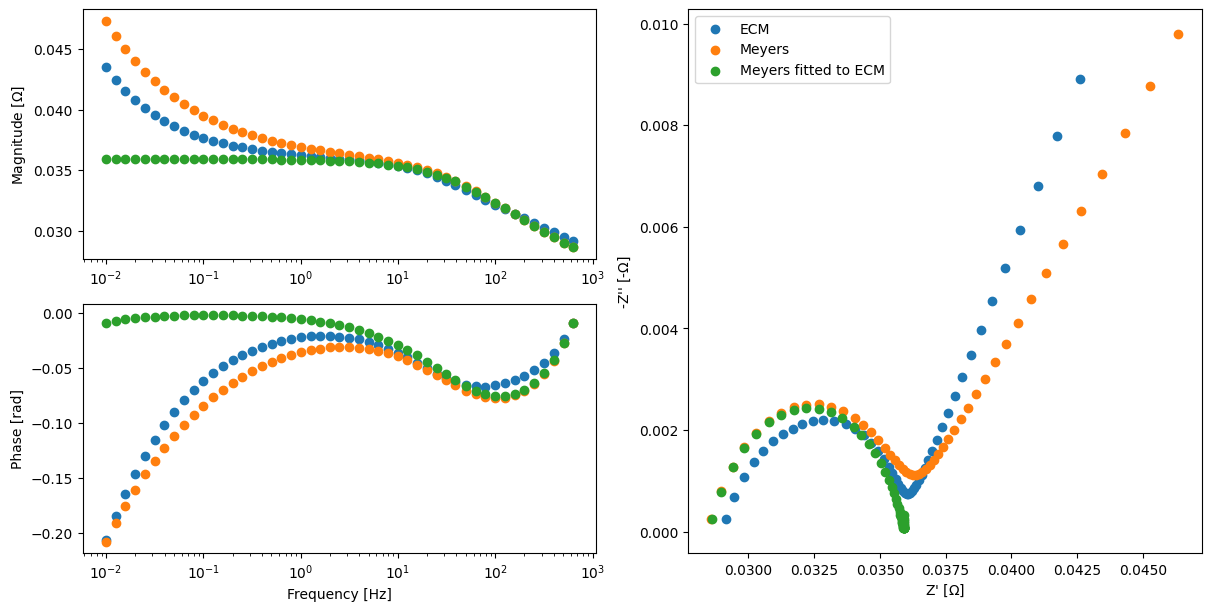

In [15]:
# Change in all parameters
from utils.Z_meyers_all_params import calc_meyers_all_Z, a_meyers_all
from utils.optimize_from_Randles import optimize_randles

final_diff, opt_meyers_f_randles = optimize_randles(i, a_meyers_all, calc_meyers_all_Z)
Z_meyers_f_randles = calc_meyers_all_Z(opt_meyers_f_randles, freq)

#final_diff2, opt_meyers_f = optimize_diff(i, a_meyers_all, calc_meyers_all_Z)
Z_meyers_opt = calc_meyers_all_Z(dict_to_list(a_meyers_all), freq) 

plot_impedance([(freq, Z_randles_opt), 
                (freq, Z_meyers_opt),
                (freq, Z_meyers_f_randles)],['ECM', 'Meyers', 'Meyers fitted to ECM'])

# Part 4: Extra

### Discharge plotting

Here, chosen parameters can be plotted. Also, the PyBaMM simulation with chosen parameters can be compared with the experimental discharge at a C/5 rate. 

Internal t = 443.869 and h = 8.97586e-16 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 443.869 and h = 8.76549e-19 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 443.869 and h = 8.76549e-19 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 443.869 and h = 1.30872e-18 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 443.869 and h = 4.01564e-24 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 443.869 and h = 4.01564e-24 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 443.869 and h = 5.68389e-24 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 443.869 and h = 1.42097e-24 are such that t + h = t on the next step. The solver will continue anyway.
Internal t = 443.869 and h = 1.42097e-24 are such that t + h = t on the 

interactive(children=(FloatSlider(value=0.0, description='t', max=4.5047462649027254, step=0.04504746264902725…

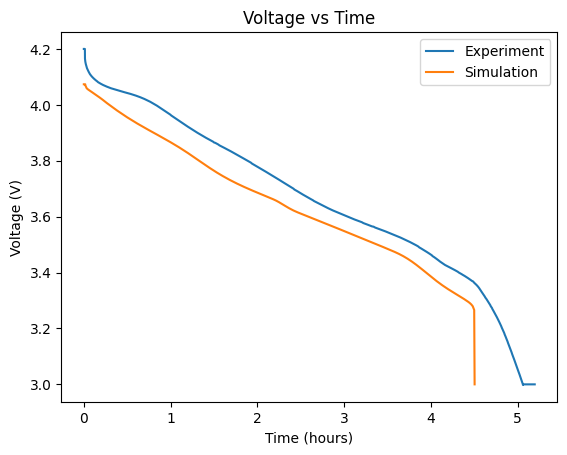

In [16]:
from utils.discharge_plot import discharge_plotting_csv, discharge_plotting_txt
path = "/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_01.015.txt"
discharge_plotting_txt(params, path)

#### We can also observe how a given parameter changes as a function of cycles 

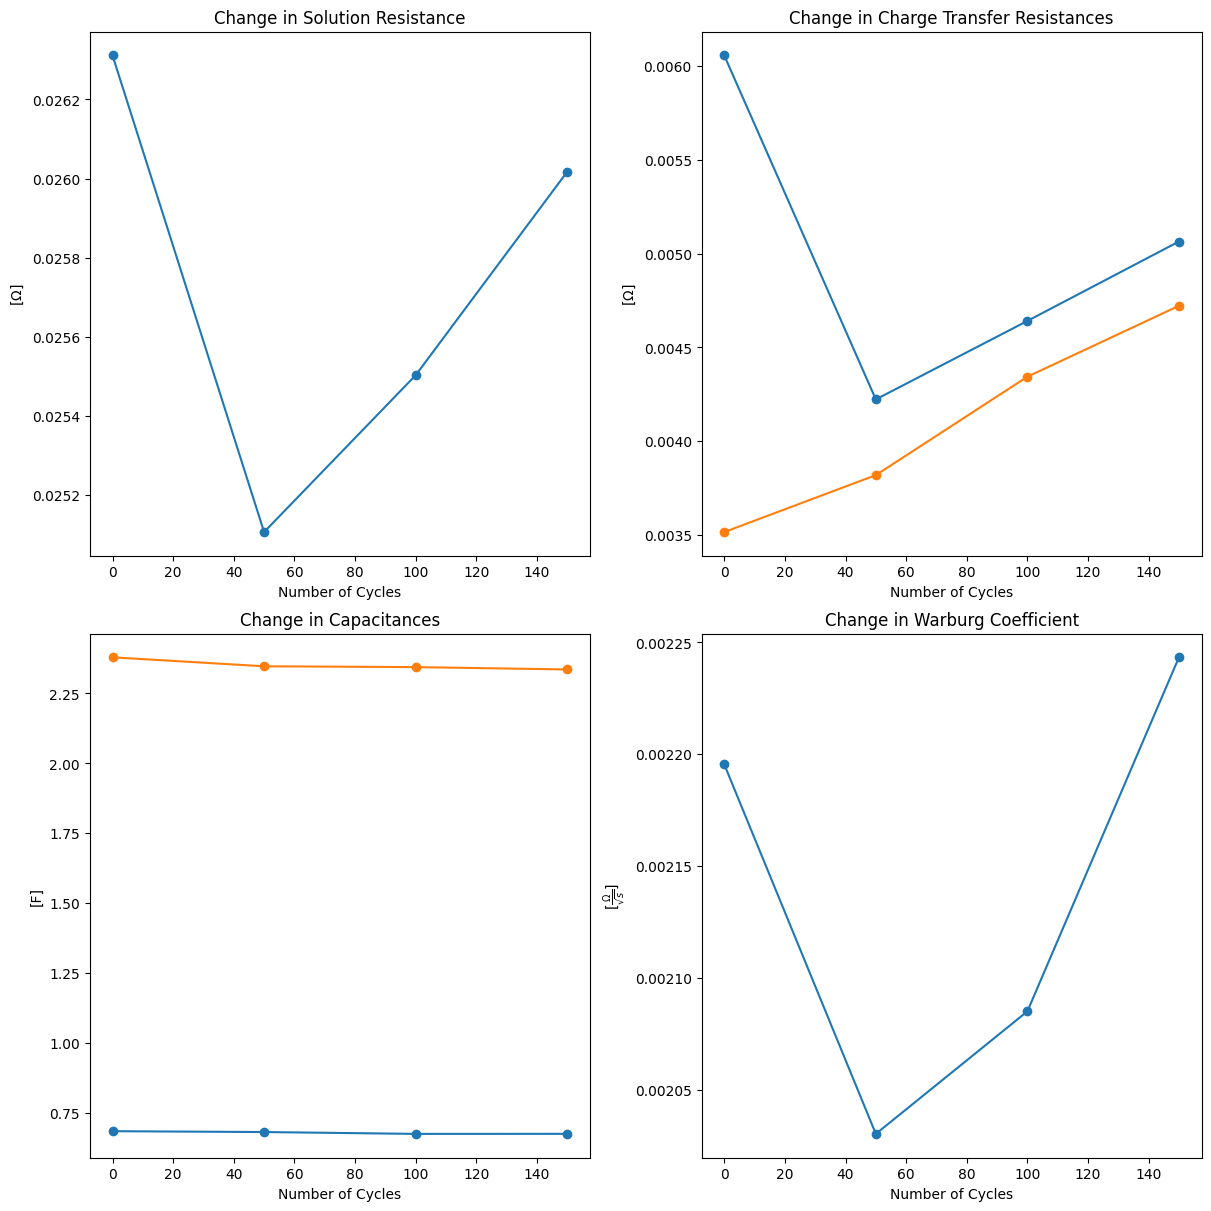

In [17]:
from utils.changes_in_params_plot import finding_params
from utils.changes_in_params_plot import plot_change_param

plot_change_param(a_randles, calc_randles_Z, optimize_diff)

### GITT cycling data plotting

In [23]:
from utils.load_cycling_data import read_txt, read_csv

MJ12s = {
    "MJ12_01": read_txt('/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_01.015.txt'), 
    "MJ12_02": read_txt('/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_02.016.txt'),
    "MJ12_03": read_csv('/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_03 - 010.csv'), 
    "MJ12_04": read_csv('/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_04 - 010.csv'), 
    "MJ12_05": read_csv('/Users/synnemard/Desktop/lithium_ion/EIS_data/MJ1_02/data-acq/MJ1_02_data-acq_05 - 016.csv')
}

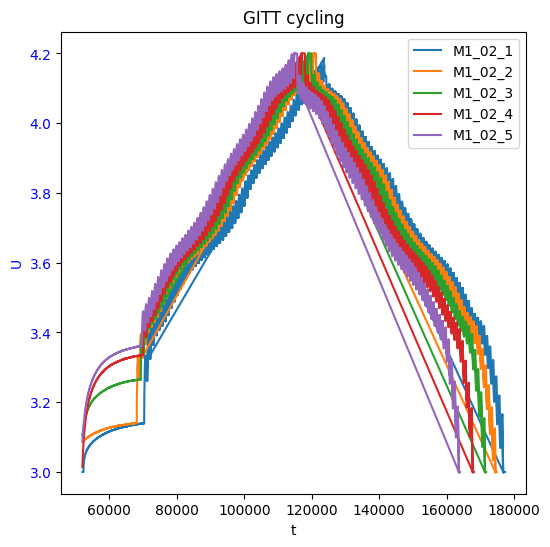

The increase in resistance from data set 1 to 2, and 2 to 3 etc., is [0.10436137071651047, 0.004672897196261859, 0.02024922118380047, 0.04672897196261721]


In [24]:
from utils.cycling_plot import plot_cycling

plot_cycling(dict_to_list(MJ12s))

### Comparing all simulations and experimental 

In [27]:

# Experimental 
i = 1
freq = np.array(get_exp_data(i, "")[1])
exp_real = np.array(get_exp_data(i, "")[0][0])
exp_imag = np.array(get_exp_data(i, "")[0][1])
Z_exp = exp_real + exp_imag*1j

# Fitted ECM 
final_diff, opt_randles_param = optimize_diff(i, a_randles, calc_randles_Z)
Z_randles_opt = calc_randles_Z(opt_randles_param, freq)

# Meyers, all parameters optimized 
Z_meyers_opt = calc_meyers_all_Z(dict_to_list(a_meyers_all), freq) 


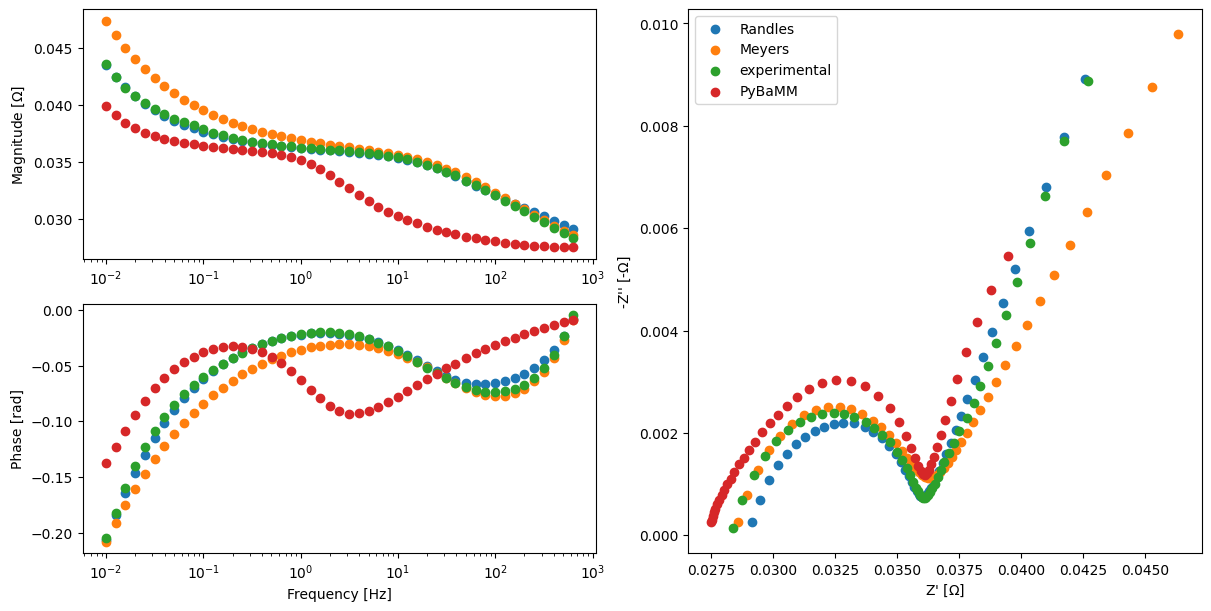

In [28]:

# Compariston plot 
plot_impedance([(freq, Z_randles_opt), 
                (freq, Z_meyers_opt),
                (freq, Z_exp), 
                (freq, Z_pybamm_after)],['Randles', 'Meyers', 'experimental', 'PyBaMM'])
